In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import seaborn as sns
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
import zipfile

## Histopathologic Cancer Detection

### Project Description
The goal of this project is to create an algorithm that identifies metastatic tissue in histopathologic scans of lymph node sections. Small image patches were taken from larger digital pathology scans.  The model should predict if the center 32x32px region of a patch contains at least one pixel of tumor tissue.Results will be evaluated on area under the ROC curve between the predicted probability and the observed target.

W. Cukierski, “Histopathologic cancer detection,” https://kaggle.com/competitions/histopathologic-cancer-detection, 2018, kaggle.

### Data Description
The training data consists of 220025 unique images, with a corresponding train_labels.csv file with ground truth for each training image by id.  Each image is a 28KB uncompressed TIF with dimensions [96,96,3].  The test data consists of 57458 unique images. Here is an example patch from the training set:

<img src="0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.jpg" 
        alt="Sample Patch" 
        width="96" 
        height="96" 
        style="display: block; margin: 0 auto" />

### Exploratory Data Analysis
A histogram will be used to check the distribution of the training labels in the set.  It appears relatively balanced.

#### Check for Balanced Labels

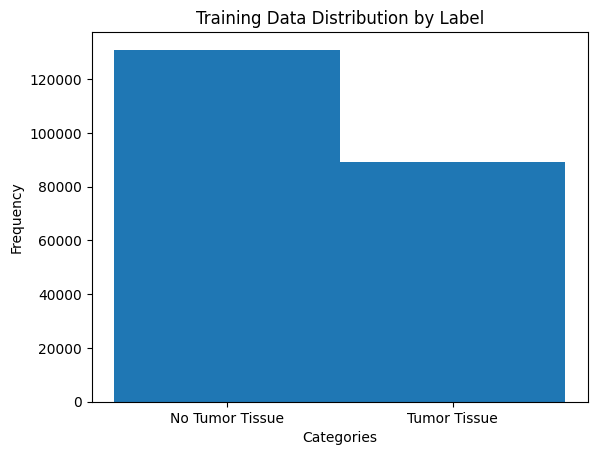

In [2]:
traindf = pd.read_csv('train_labels.csv', dtype=str)

# Create the histogram with specified bins
plt.hist(traindf.label, bins=[-0.5, 0.5, 1.5], align='mid')

# Set labels at the center of each bin
plt.xticks([0, 1], ['No Tumor Tissue', 'Tumor Tissue'])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Training Data Distribution by Label')

# Show the plot
plt.show()


In [3]:
#exact values of each label
Counter(traindf.label)

Counter({'0': 130908, '1': 89117})

#### Check Brightness and Contrast of Images in Dataset
Understanding the mean and standard deviation of pixel values is crucial because they provide insights into the overall image characteristics, such as brightness and contrast, which can help identify anomalies and inform preprocessing steps. The following functions takes in the training data and outputs visualizations of both the mean and standard devation distribution on the dataset.

Found 220025 TIFF files.

Overall Statistics:
Mean pixel value (across all images): 165.34
Standard deviation (across all images): 51.61


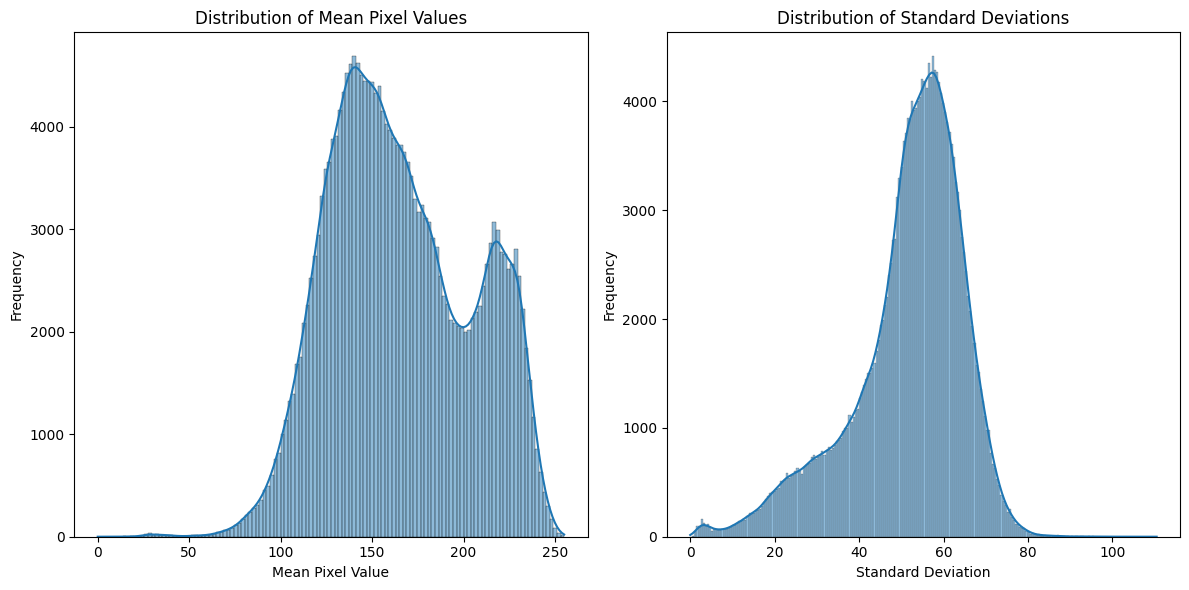

In [4]:
def tiff_eda(directory):
    """
    Performs EDA on a directory of TIFF files, handling large files and multi-page TIFFs.

    Args:
        directory (str): Path to the directory containing TIFF files.
    """

    file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(('.tif', '.tiff'))]

    if not file_paths:
        print("No TIFF files found in the specified directory.")
        return

    num_files = len(file_paths)
    print(f"Found {num_files} TIFF files.")

    all_means = []
    all_stds = []
    
    for i, file_path in enumerate(file_paths):
        try:
            with Image.open(file_path) as img:
                num_frames = getattr(img, "n_frames", 1)  # Handle single and multi-page TIFFs
                #print(f"Processing file {i+1}/{num_files}: {file_path} ({num_frames} frames)")
                
                for frame_num in range(num_frames):
                    if num_frames > 1:
                        img.seek(frame_num)
                    
                    img_array = np.array(img)
                    all_means.append(np.mean(img_array))
                    all_stds.append(np.std(img_array))

        except Exception as e:
           print(f"Error processing {file_path}: {e}")

    #Overall Statistics
    print("\nOverall Statistics:")
    print(f"Mean pixel value (across all images): {np.mean(all_means):.2f}")
    print(f"Standard deviation (across all images): {np.mean(all_stds):.2f}")

    #Distribution of Mean and Standard Deviations
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(all_means, kde=True)
    plt.title("Distribution of Mean Pixel Values")
    plt.xlabel("Mean Pixel Value")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.histplot(all_stds, kde=True)
    plt.title("Distribution of Standard Deviations")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


tiff_eda('./train')

The brightness (mean pixel value) distribution is bimodal and left skew.  Those images in the tail, seem to be very dark.  The standard deviation distribution shows that the images have good contrast.

#### Plan of Analysis
- Start with pretrained Inception model, look at different optimizers (Adam, RMSprop), vary batch sizes.
- Train VGG16 (start with randomized weights) on training set to compare results.

### Model Architecture

#### Pre-trained Inception Model
After researching the topic a bit, I learned that learning medical images on a deep model (like inception) pre trained on the imagenet dataset performs fairly well.  I decided to start with this model, because since the feature extractor portion of the model is pretrained, I know it would perform very fast.

In [5]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [6]:
pre_trained_model = InceptionV3(input_shape = (96, 96, 3), # Shape of tif images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

2025-03-16 21:08:26.430395: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-16 21:08:26.430417: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-16 21:08:26.430420: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1742184506.430433 14424890 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742184506.430450 14424890 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# freeze all the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# define callback class that stops trainiing once accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.959):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

#### Model 1 Hyper-Parameters:  Adam with learning rate of 0.0001 and binary crossentropy loss function, 20 epochs, batch size 32

In [8]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [9]:
traindf = pd.read_csv('train_labels.csv', dtype=str)

filepath_train = '/Users/sarahpfeifer/Documents/Python Code/ML/DLWeek3Project/train'
filepath_test = '/Users/sarahpfeifer/Documents/Python Code/ML/DLWeek3Project/test'
filepath_parent = '/Users/sarahpfeifer/Documents/Python Code/ML/DLWeek3Project'

# add file extention to id in df for flow from dataframe below
def append_ext(fn):
    return fn+".tif"

traindf["id"]=traindf["id"].apply(append_ext)


#### Split Train/Validation/Test 

In [10]:
datagen = ImageDataGenerator( rescale = 1.0/255., validation_split=0.10)

# Flow training images in batches of 32 using data_norm to preprocess/normalize the images
train_generator = datagen.flow_from_dataframe(
                                    dataframe=traindf,
                                    directory=filepath_train,
                                    x_col= 'id',
                                    y_col= 'label',
                                    subset = 'training',
                                    batch_size=32,
                                    seed=42,
                                    shuffle=True, 
                                    class_mode='binary', 
                                    target_size = (96,96))

# Flow training images in batches of 32 using data_norm to preprocess/normalize the images
validation_generator = datagen.flow_from_dataframe(
                                            dataframe=traindf,
                                            directory=filepath_train,
                                            x_col= 'id',
                                            y_col= 'label',
                                            subset = 'validation',
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True, 
                                            class_mode='binary', 
                                            target_size = (96,96))




# Flow test images in batches of 32 using data_norm to preprocess/normalize the test images
test_generator =  datagen.flow_from_directory( filepath_parent,
                                                        batch_size  = 32,
                                                        class_mode  = 'binary',
                                                        classes = ['test'] ,
                                                        shuffle = False,
                                                        target_size = (96, 96))

Found 198023 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.
Found 57458 images belonging to 1 classes.


#### Fit Model

In [11]:
# fit model
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 6189,
            epochs = 10,
            validation_steps = 688,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/10


/Users/sarahpfeifer/Documents/Python Code/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-03-16 21:08:30.200382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


6189/6189 - 166s - 27ms/step - acc: 0.7912 - loss: 0.4932 - val_acc: 0.8082 - val_loss: 0.4501
Epoch 2/10
6189/6189 - 160s - 26ms/step - acc: 0.8052 - loss: 0.4495 - val_acc: 0.8165 - val_loss: 0.4305
Epoch 3/10
6189/6189 - 160s - 26ms/step - acc: 0.8138 - loss: 0.4258 - val_acc: 0.8141 - val_loss: 0.4186
Epoch 4/10
6189/6189 - 159s - 26ms/step - acc: 0.8162 - loss: 0.4179 - val_acc: 0.8225 - val_loss: 0.4101
Epoch 5/10
6189/6189 - 159s - 26ms/step - acc: 0.8162 - loss: 0.4176 - val_acc: 0.8141 - val_loss: 0.4212
Epoch 6/10
6189/6189 - 158s - 26ms/step - acc: 0.8161 - loss: 0.4181 - val_acc: 0.8208 - val_loss: 0.4083
Epoch 7/10
6189/6189 - 183s - 30ms/step - acc: 0.8160 - loss: 0.4188 - val_acc: 0.8093 - val_loss: 0.4273
Epoch 8/10
6189/6189 - 855s - 138ms/step - acc: 0.8158 - loss: 0.4193 - val_acc: 0.8092 - val_loss: 0.4415
Epoch 9/10
6189/6189 - 499s - 81ms/step - acc: 0.8160 - loss: 0.4202 - val_acc: 0.7977 - val_loss: 0.4433
Epoch 10/10
6189/6189 - 631s - 102ms/step - acc: 0.8149 

#### Model 2: Pre_Trained Inception, RMSprop, learning rate 0.0001, binary crossentropy, 50 epochs, batch size 100

In [12]:
datagen = ImageDataGenerator( rescale = 1.0/255., validation_split=0.10)

# Flow training images in batches of 100 using data_norm to preprocess/normalize the images
train_generator2 = datagen.flow_from_dataframe(
                                    dataframe=traindf,
                                    directory=filepath_train,
                                    x_col= 'id',
                                    y_col= 'label',
                                    subset = 'training',
                                    batch_size=100,
                                    seed=42,
                                    shuffle=True, 
                                    class_mode='binary', 
                                    target_size = (96,96))

# Flow training images in batches of 100 using data_norm to preprocess/normalize the images
validation_generator2 = datagen.flow_from_dataframe(
                                            dataframe=traindf,
                                            directory=filepath_train,
                                            x_col= 'id',
                                            y_col= 'label',
                                            subset = 'validation',
                                            batch_size=100,
                                            seed=42,
                                            shuffle=True, 
                                            class_mode='binary', 
                                            target_size = (96,96))




# Flow test images in batches of 100 using data_norm to preprocess/normalize the test images
test_generator2 =  datagen.flow_from_directory( filepath_parent,
                                                        batch_size  = 100,
                                                        class_mode  = 'binary',
                                                        classes = ['test'] ,
                                                        shuffle = False,
                                                        target_size = (96, 96))

Found 198023 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.
Found 57458 images belonging to 1 classes.


In [13]:
model2 = Model( pre_trained_model.input, x) 
model2.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

history2 = model2.fit(
            train_generator2,
            validation_data = validation_generator2,
            steps_per_epoch = 1981,
            epochs = 20,
            validation_steps = 221,
            verbose = 2
            )

Epoch 1/20


/Users/sarahpfeifer/Documents/Python Code/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1981/1981 - 616s - 311ms/step - acc: 0.8158 - loss: 0.4166 - val_acc: 0.8107 - val_loss: 0.4350
Epoch 2/20
1981/1981 - 311s - 157ms/step - acc: 0.8182 - loss: 0.4155 - val_acc: 0.8145 - val_loss: 0.4194
Epoch 3/20
1981/1981 - 979s - 494ms/step - acc: 0.8173 - loss: 0.4154 - val_acc: 0.8167 - val_loss: 0.4172
Epoch 4/20
1981/1981 - 82s - 41ms/step - acc: 0.8174 - loss: 0.4155 - val_acc: 0.8180 - val_loss: 0.4126
Epoch 5/20
1981/1981 - 346s - 175ms/step - acc: 0.8178 - loss: 0.4160 - val_acc: 0.8219 - val_loss: 0.4104
Epoch 6/20
1981/1981 - 708s - 357ms/step - acc: 0.8174 - loss: 0.4166 - val_acc: 0.8060 - val_loss: 0.4329
Epoch 7/20
1981/1981 - 86s - 44ms/step - acc: 0.8179 - loss: 0.4155 - val_acc: 0.8181 - val_loss: 0.4163
Epoch 8/20
1981/1981 - 578s - 292ms/step - acc: 0.8173 - loss: 0.4165 - val_acc: 0.8216 - val_loss: 0.4076
Epoch 9/20
1981/1981 - 1021s - 515ms/step - acc: 0.8168 - loss: 0.4166 - val_acc: 0.8093 - val_loss: 0.4303
Epoch 10/20
1981/1981 - 79s - 40ms/step - acc: 0.81

#### Model 3: VGG16 randomized weights, Adam, learning rate decay, max pooling, batch size 100,

In [14]:
datagen = ImageDataGenerator( rescale = 1.0/255.)

# Flow training images in batches of 100 using data_norm to preprocess/normalize the images
train_generator3 = datagen.flow_from_dataframe(
                                    dataframe=traindf,
                                    directory=filepath_train,
                                    x_col= 'id',
                                    y_col= 'label',
                                    batch_size=100,
                                    seed=42,
                                    shuffle=True, 
                                    class_mode='binary', 
                                    target_size = (96,96))

# Flow test images in batches of 100 using data_norm to preprocess/normalize the test images
test_generator3 =  datagen.flow_from_directory( filepath_parent,
                                                        batch_size  = 100,
                                                        class_mode  = 'binary',
                                                        classes = ['test'] ,
                                                        shuffle = False,
                                                        target_size = (96, 96))

Found 220025 validated image filenames belonging to 2 classes.
Found 57458 images belonging to 1 classes.


In [44]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(96,96,3),
    pooling='max'
)

model3 = tf.keras.models.Sequential()
model3.add(base_model)
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.00000001),
    metrics=['accuracy']
)

model3.summary()
history3 = model3.fit(
    train_generator3,
    steps_per_epoch=2201,
    epochs=10
)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 14,715,201 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 495s 224ms/step - accuracy: 0.5756 - loss: 0.6926
Epoch 2/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 578s 263ms/step - accuracy: 0.5945 - loss: 0.6915
Epoch 3/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 588s 267ms/step - accuracy: 0.5977 - loss: 0.6900
Epoch 4/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 547s 248ms/step - accuracy: 0.5927 - loss: 0.6884
Epoch 5/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 546s 248ms/step - accuracy: 0.5946 - loss: 0.6862
Epoch 6/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 557s 253ms/step - accuracy: 0.5946 - loss: 0.6836
Epoch 7/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 521s 236ms/step - accuracy: 0.5940 - loss: 0.6808
Epoch 8/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 507s 230ms/step - accuracy: 0.5962 - loss: 0.6776
Epoch 9/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 497s 226ms/step - accuracy: 0.5957 - loss: 0.6749
Epoch 10/10
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 607s 276ms/step - accuracy: 0.5954 - loss: 0.6729


#### Model 4 CNN with less parameters.

In [54]:
    model4 = keras.Sequential([
                        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
                        MaxPool2D((2, 2)),
                        Conv2D(64, (3, 3), activation='relu'),
                        MaxPool2D((2, 2)),
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(1, activation='sigmoid')
])

model4.compile(optimizer=Adam(0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4.summary()


/Users/sarahpfeifer/Documents/Python Code/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_119 (Conv2D)             │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
history4 = model4.fit(train_generator2,
            validation_data = validation_generator2,
            steps_per_epoch = 1981,
            epochs = 30,
            validation_steps = 221,
            verbose = 2)

Epoch 1/30
1981/1981 - 74s - 37ms/step - accuracy: 0.8256 - loss: 0.3944 - val_accuracy: 0.8215 - val_loss: 0.4026
Epoch 2/30
1981/1981 - 72s - 37ms/step - accuracy: 0.8274 - loss: 0.3918 - val_accuracy: 0.8240 - val_loss: 0.4002
Epoch 3/30
1981/1981 - 73s - 37ms/step - accuracy: 0.8279 - loss: 0.3902 - val_accuracy: 0.8220 - val_loss: 0.4035
Epoch 4/30
1981/1981 - 73s - 37ms/step - accuracy: 0.8286 - loss: 0.3896 - val_accuracy: 0.8257 - val_loss: 0.3968
Epoch 5/30
1981/1981 - 74s - 37ms/step - accuracy: 0.8282 - loss: 0.3887 - val_accuracy: 0.8262 - val_loss: 0.3966
Epoch 6/30
1981/1981 - 74s - 37ms/step - accuracy: 0.8287 - loss: 0.3874 - val_accuracy: 0.8198 - val_loss: 0.4041
Epoch 7/30
1981/1981 - 74s - 37ms/step - accuracy: 0.8282 - loss: 0.3880 - val_accuracy: 0.8148 - val_loss: 0.4212
Epoch 8/30
1981/1981 - 74s - 37ms/step - accuracy: 0.8290 - loss: 0.3870 - val_accuracy: 0.8277 - val_loss: 0.3926
Epoch 9/30
1981/1981 - 74s - 37ms/step - accuracy: 0.8305 - loss: 0.3846 - val_a

### Results/Analysis

#### Model 1: Adam, learning rate 0.0001, binary crossentropy loss function, 20 epochs
This model scored ~ .80.  Not bad for using pretrained model.  Below are plots of train vs validation accuracy and loss.  
<img src="Model1Submission.png" 
        alt="Sample Patch" 
        width="700" 
        height="100" 
        style="display: block; margin: 0 auto" />


In [ ]:
# plot accuracy vs loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Make predictions
predictions = model.predict(test_generator, steps=len(test_generator))

In [ ]:
# Get the filenames from the generator
filenames = test_generator.filenames
# flatten predictions of df col
list_ = predictions.tolist()
flat_list = [item[0] for item in list_]
test_pred = pd.DataFrame({'id': filenames, 'label': flat_list})
test_pred.loc[test_pred['label'] > 0.5, 'label'] = 1
test_pred.loc[test_pred['label'] < 0.5, 'label'] = 0

Counter(test_pred['label'])

In [ ]:
# create csv for submission
test_pred['id'] = test_pred['id'].str[5:-4]
test_pred.to_csv('predictions1.csv', index=False)


#### Model 2: RMSprop, learning rate 0.0001, binary crossentropy
The accuracy of this model starts where the Adam model flattened out.  But doesn't seem to change much over the 50 epochs.
<img src="Model2Submission.png" 
        alt="Sample Patch" 
        width="700" 
        height="100" 
        style="display: block; margin: 0 auto" />


In [ ]:
# plot accuracy vs loss
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Make predictions
predictions2 = model2.predict(test_generator, steps=len(test_generator))
# flatten predictions of df col
list_ = predictions2.tolist()
flat_list2 = [item[0] for item in list_]
# Create the DataFrame
test_pred2 = pd.DataFrame({'id': filenames, 'label': flat_list2})
test_pred2.loc[test_pred2['label'] > 0.5, 'label'] = 1
test_pred2.loc[test_pred2['label'] < 0.5, 'label'] = 0

Counter(test_pred2['label'])

In [ ]:
# create csv for submission
test_pred2['id'] = test_pred2['id'].str[5:-4]
test_pred2.to_csv('predictions2.csv', index=False)

#### Model 3:  VGG16

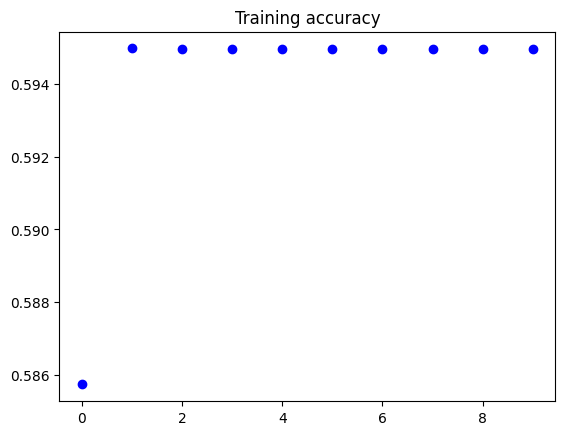

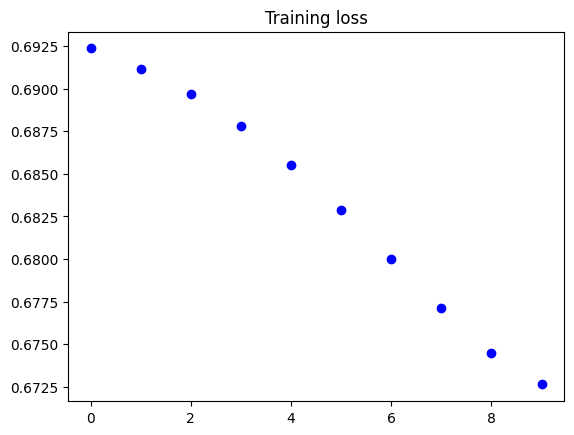

In [46]:
# plot accuracy vs loss
acc = history3.history['accuracy']
#val_acc = history3.history['val_acc']
loss = history3.history['loss']
#val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
#plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
#plt.legend()

plt.show()

In [47]:
# Make predictions
predictions3 = model3.predict(test_generator, steps=len(test_generator))
filenames = test_generator.filenames
# flatten predictions of df col
list_ = predictions3.tolist()
flat_list3 = [item[0] for item in list_]
# Create the DataFrame
test_pred3 = pd.DataFrame({'id': filenames, 'label': flat_list3})
test_pred3.loc[test_pred3['label'] > 0.5, 'label'] = 1
test_pred3.loc[test_pred3['label'] < 0.5, 'label'] = 0
#predicted all zero labels
Counter(test_pred3['label'])


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step


Counter({0.0: 57458})

In [48]:
# create csv for submission, did not submit because all predictions are very close to the same value, even with very small learning rate.
test_pred3['id'] = test_pred3['id'].str[5:-4]
test_pred3.to_csv('predictions3.csv', index=False)
predictions3

array([[0.42312768],
       [0.42374173],
       [0.42556417],
       ...,
       [0.41390833],
       [0.42113918],
       [0.41161865]], dtype=float32)

#### Model 4
Even though this was a much simpler model, the accuracy remained the same and the deeper pretrained inception model.
<img src="Model4Submission.png" 
        alt="Sample Patch" 
        width="600" 
        height="100" 
        style="display: block; margin: 0 auto" />



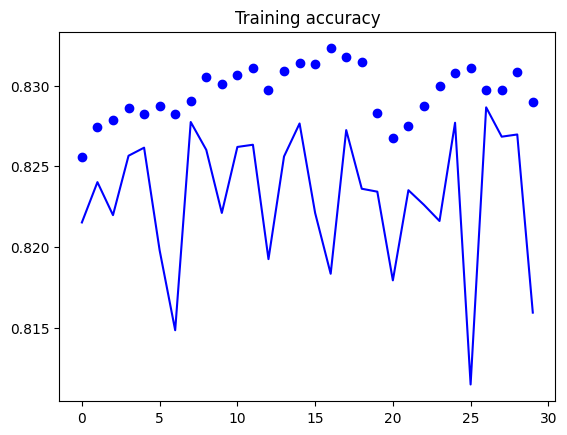

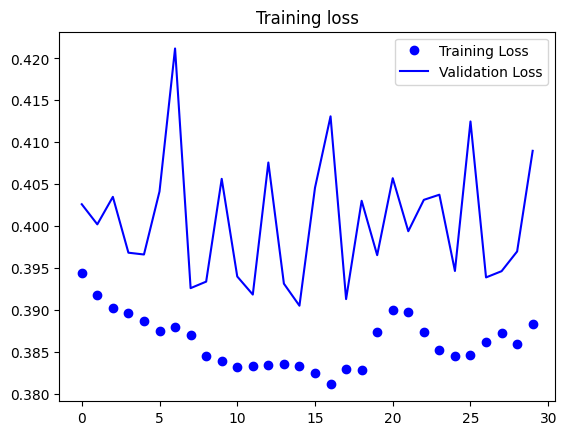

In [60]:
# plot accuracy vs loss
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [61]:
# Make predictions
predictions4 = model4.predict(test_generator, steps=len(test_generator))
filenames = test_generator.filenames
# flatten predictions of df col
list_ = predictions4.tolist()
flat_list4 = [item[0] for item in list_]
# Create the DataFrame
test_pred4 = pd.DataFrame({'id': filenames, 'label': flat_list4})
test_pred4.loc[test_pred4['label'] > 0.5, 'label'] = 1
test_pred4.loc[test_pred4['label'] < 0.5, 'label'] = 0
#predicted all zero labels
Counter(test_pred4['label'])

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


Counter({0.0: 32990, 1.0: 24468})

In [62]:
# create csv for submission
test_pred4['id'] = test_pred4['id'].str[5:-4]
test_pred4.to_csv('predictions4.csv', index=False)

### Conclusions

- Initially by steps per epoch and validation steps were off.  This created volitility in the accuracy and loss.  To keep the notebook a reasonable size, I discarded those models, but below are screenshots of the acuracy and loss plots.

<img src="plot1.png" style="width:22%">
<img src="plot2.png" style="width:22%">
<img src="plot3.png" style="width:22%">
<img src="plot4.png" style="width:22%">

- To increase performance of all models, I would include the validation set (made out of training data) in the training.
- When I switched to run the models using GPUs, the results changed drastically.  I'm curious as to why that would be.
- VGG16 seemed too big of a model to train, and led to overfitting. Using a learning rate decay didn't seem to help the issue. Here were the accuracy and loss by epoch using learning rate decay, but starting with lr=0.001:

<img src="VGGof1.png" style="width:45%">
<img src="VGGof2.png" style="width:45%">

it didn't improve even with a drastic lowering of learning rate. This model performed considerably worse on training set, even after changing hyper-paramers multiple times, so I didn't submit it to kaggle.

- All models used Binary Crossentropy for loss function.  

<center>

| Model                         | Hyper-Parameters                   | Score  |
|:-----------------------------|:----------------------------------:|-------:|
| 1: Pretrained Inception       | Adam, lr=0.00001, batch size=32    | .8016 |
| 2: Pretrained Inception       | RMSprop, lr=0.00001, batch size=100| .7983 |
| 3: VGG16                      | Adam, lr=0.00000001, batch size=100|   dns |
|4: Simple CNN w MaxPooling     |Adam, lr=0.00001, batch size=100    |       | 

</center>



### Learning/Takeaways
- CNNs take an incredible amount of time, energy, compute to train.
- Overfitting is easy to do!
- Using GPU saved considerable time.
- Hyper-parameter intuition doesn't necessary transfer to other models.